In [286]:
from khaiii import KhaiiiApi
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

import os
import zipfile
import sys
import pandas as pd
import re
import warnings
import time
import urllib
import requests

api = KhaiiiApi()
font_path = './font/NotoSansCJKkr-Bold.otf'
url = 'https://www.mandarinstone.com/app/uploads/2017/09/Geometric-Cube-Decor-Ebony_Dove_White-Swatch.jpg'
path_dir = './data'

def get_file_list (path):
    return os.listdir(path)

def get_data (file_idx, file_list): 
    file_path = f'{path_dir}/{file_list[file_idx]}'
    data = pd.DataFrame()
    file = pd.read_csv(file_path, 
                       error_bad_lines=False, 
                       engine='python', 
                       warn_bad_lines=False)
    data = pd.concat([data,file])
    return data['content']

file_list = get_file_list(path_dir)
text_data = get_data(0, file_list)

In [301]:
def get_words (data, corpus):
    word = list()
    for i in range(len(data)):
        for text in KhaiiiApi().analyze(str(text_data[i])):
            temp = str(text).split("\t")[1].split('+')
            word.extend(corpus.findall(str(temp)))

    return word

noun = '[ㄱ-ㅎ가-힣a-zA-Z]{2,}(?=\/NNG)|[ㄱ-ㅎ가-힣a-zA-Z]{2,}(?=\/NNP)'
foreign = '[ㄱ-ㅎ가-힣a-zA-Z]{2,}(?=\/SL)'
adjective = '[ㄱ-ㅎ가-힣a-zA-Z]{2,}(?=\/VA)'
verb = '[ㄱ-ㅎ가-힣a-zA-Z]{2,}(?=\/VV)'

corpus = re.compile(noun+'|'+foreign+'|'+adjective+'|'+verb)
word = get_words(text_data, corpus)

In [304]:
def get_word_count (words):
    return (
        pd.DataFrame(words, columns=['word'])
        .groupby('word')
        .size()
        .reset_index(name='count')
        .sort_values(['count'], ascending=False)
        .reset_index(drop=True)
    )

word_count = get_word_count(word)

In [324]:
# modify stop_words

# behavior
# word_count.loc[word_count['word'] == '일어나', 'word'] = '일어남'
# word_count.loc[word_count['word'] == '줄이', 'word'] = '줄임'
# word_count.loc[word_count['word'] == '빠르', 'word'] = '빠름'

# test
word_count.loc[word_count['word'] == '비싸', 'word'] = '비쌈'
word_count.loc[word_count['word'] == '새롭', 'word'] = '새로움'
word_count.loc[word_count['word'] == '모르', 'word'] = '모름'

# recommend
# word_count.loc[word_count['word'] == '알리', 'word'] = '알림'
# word_count.loc[word_count['word'] == '빼놓', 'word'] = '빼놓음'
# word_count.loc[word_count['word'] == '잠그', 'word'] = '잠금'
# word_count.loc[word_count['word'] == '느끼', 'word'] = '느낌'

# purchase
# word_count.loc[word_count['word'] == '빠르', 'word'] = '빠름'

In [315]:
# remove stop_words
stop_words = (
    list()
    .extend([
#     'nan', '위하', '화재시', '경우', '모르', '대하', '통하', '의하', '만약',
#     '느끼', '나오', '알아보', '정도', '인하', '의양이', '이외', '우선', '대하', '내용', '설명', '경우', '차원', '사용', '테스트', '위하', '이상', '판단', '가능', '부분', '관련', '생각', '경호', '대중'
#     '강아지', '통하', '미연', '만약', '잠구', '비상', '대비', '방법', 'off', '외출', '위치', '추천', '위하', '주위', '정도', '차원', '사람', '이유', '경우', '이하내용', '대하', '소개', '판단', '인하', '의구심', '요즘', '부담', '의향', '느낌', '생각'
#         '위하', '경우', '미연', '생각', '일어나', '만약', '대하', '줄이', '화재시', '가능', '구매', '통하', '이나', '완동물', '의하', '최소', '차원', 'IoT'
    ]))

In [312]:
def get_new_count (old_word_count):
    return (
        old_word_count
        .groupby(['word'])
        .sum()
        .sort_values(['count'], 
                     ascending=False)
        .astype(int)['count']
    )
def get_new_word (old_word_count):
    return (
        old_word_count
        .groupby(['word'])
        .sum()
        .sort_values(['count'], 
                     ascending=False)
        .index
    )
def get_filtered_word_count (stop_words, old_word_count):
    for i in range(len(stop_words)):
        old_word_count = (
            old_word_count[old_word_count['word'] != stop_words[i]]
            .reset_index()
            .drop(['index'],
                  axis=1)
        )
    
    new_count = get_new_count(old_word_count)
    new_word = get_new_word(old_word_count)
    word_count = pd.DataFrame(list(zip(new_word, new_count)),
                              columns=['word','count'])
    return word_count

new_word_count = get_filtered_word_count(stop_words, word_count)

# result
new_word_count.head()

,word,count
0,생각,9
1,부담,8
2,비싸,8
3,비용,6
4,느끼,5


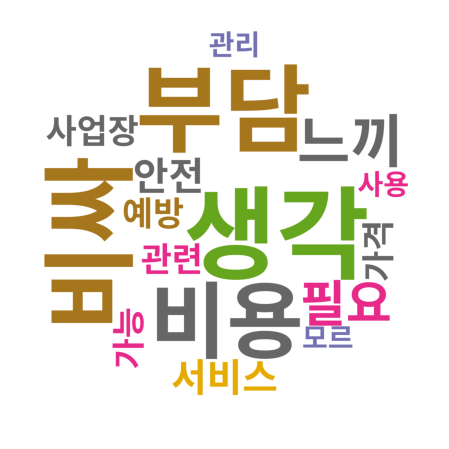

In [309]:
# word_cloud
mask = np.array(Image.open(requests.get(url, stream=True).raw))

def get_word_dict (cloud_vol):
    word_dict = dict()
    for i in range(cloud_vol):
        word_dict[new_word_count['word'][i]] = new_word_count['count'][i]
        
    return word_dict
def get_word_cloud (word_dict):
    %matplotlib inline
    wc = WordCloud(font_path=font_path,
                   min_font_size = .5,
                   colormap='Dark2',
                   background_color='white', 
                   width=800,
                   height=800,
                   mask=mask)

    cloud = wc.generate_from_frequencies(word_dict)
    plt.figure(figsize=(10,8))
    plt.axis('off')
    plt.imshow(cloud)

word_dict = get_word_dict(16)
get_word_cloud(word_dict)